# Figure 9

Load librairies

In [31]:
import pandas as pd                 # Data
import numpy as np                  # Data
import matplotlib.pyplot as plt     # Plot
from scipy.stats import rankdata    # Return period

Use Latex Font

In [32]:
plt.rcParams.update({'text.usetex': True,
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'font.size': 11,
                     'axes.labelsize': 11,
                     'legend.fontsize': 11,
                     'xtick.labelsize': 9,
                     'ytick.labelsize': 9})  

# Data

Function to identify a RES drought.
 - Select only the values below the selected threshold
 - Group consecutive True/False values and count consecutive hours below threshold
 - Find the end of each drought event
 - Adjust the index to point to the start time of each drought event

In [33]:
def identify_drought(time_series: pd.Series,threshold:float):
    events_thresh = time_series < threshold
    raw_events = events_thresh.groupby(events_thresh.ne(events_thresh.shift()).cumsum()).cumsum()
    identified_events = raw_events[(raw_events.shift(1) < raw_events) & (raw_events.shift(-1) < raw_events)]
    identified_events.index = pd.Index([date - pd.Timedelta(identified_events.loc[date] - 1, unit = 'h') for date in identified_events.index])
    return identified_events

Function to calculate the droughts duration return periods
 - Rank all the events
 - 

In [34]:
def calculate_return_period(droughts:pd.DataFrame):
    droughts_sorted = droughts.sort_values('Duration')
    droughts_sorted['rank'] = rankdata(droughts_sorted['Duration'])
    droughts_sorted['exceedance_probability'] = (len(droughts_sorted) - droughts_sorted['rank'] + 1) / (len(droughts_sorted) + 1)
    droughts_sorted['return_period'] = 1. / droughts_sorted['exceedance_probability']
    droughts_sorted['return_years'] = droughts_sorted['return_period'] * 44 / len(droughts_sorted)
    return droughts_sorted

In [35]:
def calculate_return_period2(droughts:pd.DataFrame):
    droughts_sorted = droughts.sort_values('Duration')
    droughts_sorted['rank'] = rankdata(droughts_sorted['Duration'])
    droughts_sorted['return_period'] = (len(droughts_sorted) + 1) / (len(droughts_sorted) - droughts_sorted['rank'] + 1)
    droughts_sorted['return_years'] = droughts_sorted['return_period'] * 44 / len(droughts_sorted)
    return droughts_sorted

Read CF data

In [36]:
df_combine = pd.read_csv('../Data/cf_analysis_1979-2023.csv',
                         index_col = 0,
                         parse_dates = True)

Create moving average

In [37]:
df_combine_avg = df_combine.rolling('D', min_periods=24, center=True).mean()

Repeat the function *identify_droughts* for all time series from the *df_combine_avg* data frame.

The events for one series are stored in a pandas Series and those series are stored in a dictonary *droughts_dict*.

In [38]:
droughts_dict = {}

for column in df_combine_avg:
    raw_droughts = identify_drought(df_combine_avg[column], 0.1)
    droughts = raw_droughts[raw_droughts > 24]
    droughts_df = pd.DataFrame(droughts)
    droughts_df = droughts_df.set_axis(['Duration'], axis = 1)
    droughts_dict[column] = droughts_df

In [39]:
return_dict = {}
for key, value in droughts_dict.items():
    return_dict[key] = calculate_return_period(value)

# Plot

In [40]:
def plot_lines(axs):
    axs[2].plot((0.03, 45), (5,5), '--k', alpha = 0.6)
    axs[3].plot((0.03, 45), (5,5), '--k', alpha = 0.6)

    axs[2].plot((0.57, 0.57), (0,5), '--', color = color_models[0])
    axs[3].plot((4, 4), (0,5), '--', color = color_models[0])

    axs[2].plot((1.4, 1.4), (0,5), '--', color = color_models[1])
    axs[3].plot((5.5, 5.5), (0,5), '--', color = color_models[1])

    axs[2].plot((1.15, 1.15), (0,5), '--', color = color_models[2])
    axs[3].plot((4.9, 4.9), (0,5), '--', color = color_models[2])

In [41]:
label_name = ['ATL', 'C3S GRD', 'C3S NAT']
title_name = ['a) Wind Only ', 'b) PV Only', 'c) 91\% Wind / 9\% PV', 'd) 57\% Wind / 43\% PV']
color_models = ['#B03024', '#348ABD', '#988ED5']
sign_models = ['^', 'o', 's']

categories = {'wind':         ['Wind ATL', 'Wind C3S GRD', 'Wind C3S NAT'],
              'solar':        ['Solar ATL', 'Solar C3S GRD', 'Solar C3S NAT'],
              'combine_2023': ['Combine ATL 2023', 'Combine C3S GRD 2023', 'Combine C3S NAT 2023'],
              'combine_2030': ['Combine ATL 2030', 'Combine C3S GRD 2030', 'Combine C3S NAT 2030']}

cm = 1/2.54

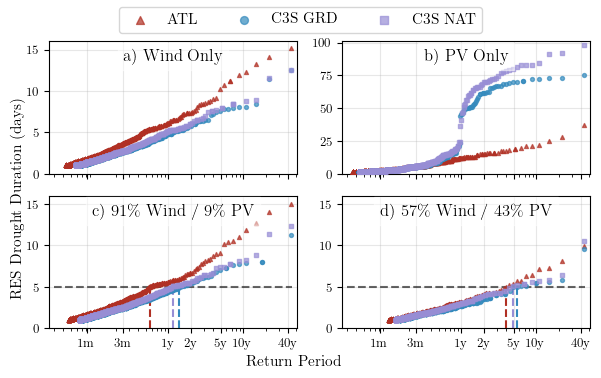

In [ ]:
fig, axs = plt.subplots(2, 2, 
                        figsize = (16*cm, 10*cm), 
                        sharex = True)
axs = axs.flatten()

for idx, (category, datasets_in_category) in enumerate(categories.items()):
    ax = axs[idx]

    for i, name in enumerate(datasets_in_category):
        ax.scatter(return_dict[name]['return_years'], return_dict[name]['Duration'] / 24, 
                   s = 8,
                   marker = sign_models[i],
                   color = color_models[i],
                   alpha = 0.7,
                   zorder = 3)

    # Axis properties
    ax.margins(0.02)

    ax.set_xscale('log')
    ax.set_xticks([7/365, 30/365, 91/365, 1, 2, 5, 10, 40])
    ax.set_xticklabels(['1w', '1m', '3m', '1y', '2y', '5y', '10y', '40y'])

    if idx != 1:
        ax.set_ylim(0,16)
    else:
        ax.set_ylim(0,101)
        ax.set_yticks(range(0, 101, 25))

    ax.set_title(title_name[idx], 
                 x = 0.5, y = 1,
                 pad = -14,
                 fontsize = 12, 
                 bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor = 'white'))   
    ax.grid(True, alpha = 0.3, zorder = 0)



plot_lines(axs)

# Legend
fig.legend(labels = label_name,
           loc = 'upper center',
           ncol = 3,
           markerscale = 2,
           fontsize = 11)

fig.supxlabel('Return Period', y = 0.07)
fig.supylabel('RES Drought Duration (days)', x = 0.05)

fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.savefig('09_analysis_return_periods.pdf', bbox_inches = 'tight')